In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import xgboost
import numpy as np
from scipy.sparse import csr_matrix, diags
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [25]:
# Adjacency generating functions
def make_adjacency(rf, X):
    leafIDs = rf.apply(X)
    n_samples, n_trees = leafIDs.shape
    max_leaf = leafIDs.max()
    # give each (tree, leaf) a unique global ID
    leafIDs_global = (leafIDs + np.arange(n_trees) * max_leaf).astype(int)

    # Build sparse membership matrix M
    row_ind = np.repeat(np.arange(n_samples), n_trees)
    col_ind = leafIDs_global.ravel()
    data = np.ones_like(row_ind, dtype=np.float32)

    M = csr_matrix((data, (row_ind, col_ind)), shape=(n_samples, col_ind.max() + 1))

    # leaf sizes and weights
    leaf_sizes = np.array(M.sum(axis=0)).ravel()
    leaf_weights = 1.0 / np.maximum(leaf_sizes, 1)  # avoid div by zero

    M_norm = M @ diags(leaf_weights)
    A = (M_norm @ M.T) / n_trees
    
    metadata = {
        "leaf_weights": leaf_weights,
        "leafIDs": leafIDs,
        'n_trees': n_trees,
        'max_leaf': max_leaf,
        'M_train': M
    }
    return A.toarray(), metadata

def new_adjacency(rf, X_new, metadata):
    M_train = metadata["M_train"]
    leaf_weights = metadata["leaf_weights"]
    n_trees = metadata["n_trees"]
    max_leaf = metadata["max_leaf"]
    
    n_new = X_new.shape[0]
    
    # Get terminal nodes for new data
    leafIDs_new = rf.apply(X_new)
    leafIDs_global_new = (leafIDs_new + np.arange(n_trees) * max_leaf).astype(int)
    
    # Merge train and new leaves
    leafIDs_global_train = M_train.indices
    leafIDs_union = np.union1d(leafIDs_global_train, leafIDs_global_new.ravel())
    
    # Map global IDs to columns
    id_map_train = {lid: i for i, lid in enumerate(leafIDs_union)}
    id_map_new = {lid: i for i, lid in enumerate(leafIDs_union)}
    
    # Sparse matrices
    row_ind_train = np.repeat(np.arange(M_train.shape[0]), n_trees)
    col_ind_train = np.array([id_map_train[lid] for lid in M_train.indices])
    M_train_sparse = csr_matrix((np.ones_like(row_ind_train), 
                                 (row_ind_train, col_ind_train)),
                                shape=(M_train.shape[0], len(leafIDs_union)))
    
    row_ind_new = np.repeat(np.arange(n_new), n_trees)
    col_ind_new = np.array([id_map_new[lid] for lid in leafIDs_global_new.ravel()])
    M_new_sparse = csr_matrix((np.ones_like(row_ind_new), 
                               (row_ind_new, col_ind_new)),
                              shape=(n_new, len(leafIDs_union)))
    
    # Normalize new matrix
    leaf_sizes = np.array(M_train_sparse.sum(axis=0)).ravel()
    leaf_weights = 1.0 / leaf_sizes
    leaf_weights[~np.isfinite(leaf_weights)] = 0
    M_new_norm = M_new_sparse @ diags(leaf_weights)
    
    # Weighted adjacency for new data vs training
    A_new = (M_train_sparse @ M_new_norm.T).T / n_trees
    return A_new.toarray()

In [26]:
data = pd.read_csv('data_42.csv', index_col=0)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1,
                                                  random_state=1234)
skrf = RandomForestClassifier(max_depth=3, random_state=0)
skrf.fit(X_train, y_train)
skpreds = skrf.predict(X_val)

# access trees
# trees = skrf.estimators_
A, metadata = make_adjacency(skrf, X_train)
A_new = new_adjacency(skrf, X_val, metadata)
D = 1-A

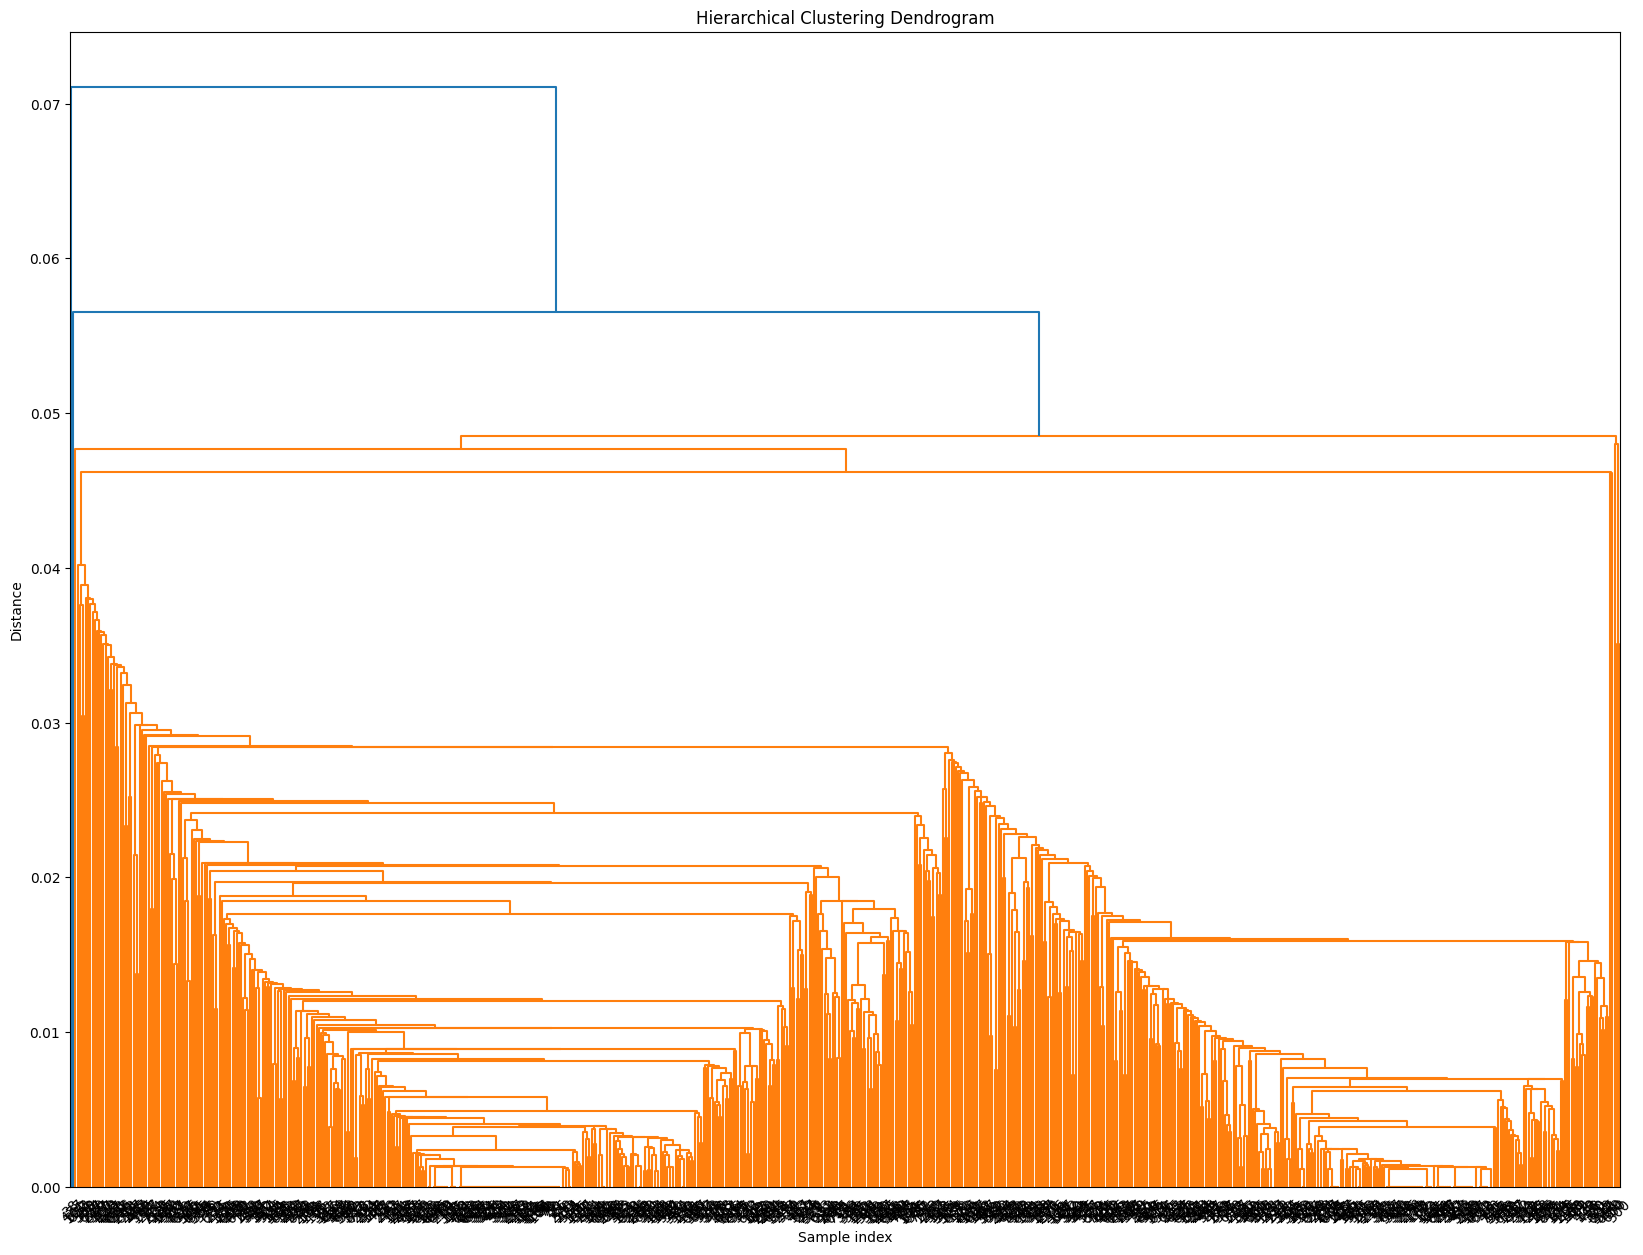

In [28]:
from scipy.cluster.hierarchy import linkage, dendrogram, to_tree

Z = linkage(D, method = 'single')
plt.figure(figsize=(20, 15))
dendrogram(Z, truncate_mode=None, leaf_rotation=45, leaf_font_size=10.)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample index")
plt.ylabel("Distance")
plt.show()

In [29]:
rootnode, nodelist = to_tree(Z, rd=True)

In [150]:
class DDT(nn.Module):
    def __init__(self, input_dim, root, nodes, output_dim, use_cuda=False):
        super(DDT, self).__init__()
        self.root = root
        self.nodes = {node.id: node for node in nodes}
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.device = torch.device("cuda" if use_cuda else "cpu")    

        self.split_layers = nn.ModuleDict()
        for nid, node in self.nodes.items():
            if node.left is not None and node.right is not None:
                self.split_layers[str(nid)] = nn.Sequential(
                    nn.Linear(input_dim, 1, bias = True),
                    nn.Sigmoid()
                )
    def forward(self, X):
        batch_size = X.size(0)
        mu = {nid: torch.zeros(batch_size, 1, device=self.device)
              for nid in self.nodes}
        mu[self.root.id] = torch.ones(batch_size, 1, device = self.device)

        stack = [self.root.id]
        while stack:
            nid = stack.pop()
            node = self.nodes[nid]

            if node.left is None and node.right is None:
                continue
            
            p_left = self.split_layers[str(nid)](X)
            mu[node.left.id] += mu[nid] * p_left
            mu[node.right.id] += mu[nid] * (1 - p_left)

            stack.extend([node.left.id, node.right.id])

        leaf_probs = [mu[nid] for nid, node in self.nodes.items() if node.left is None]
        leaf_probs = torch.cat(leaf_probs, dim=1)

        

        # top_probs, top_idx = torch.topk(leaf_probs, k=100, dim=1)
        # mask = torch.zeros_like(leaf_probs)
        # mask.scatter_(1, top_idx, 1.0)
        # leaf_probs = leaf_probs * mask

        leaf_probs = leaf_probs / (leaf_probs.sum(dim=1, keepdim=True))
        #leaf_probs = torch.softmax(leaf_probs, dim=1)
        

        return leaf_probs
class TabularDataset(Dataset):
    def __init__(self, X, y):
        """
        X: DataFrame (features)
        y: numpy array (labels)
        """
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [164]:
input_dim = 10
output_dim = X_train.shape[0]
lr = 0.01
batch_size = 128
epochs = 100
log_interval = 50
use_cuda = False
weight_decay = 5e-4


In [165]:
tree = DDT(input_dim, rootnode, nodelist, output_dim, use_cuda)
optimizer = torch.optim.Adam(tree.parameters(),
                             lr=lr)

In [166]:
train_dataset = TabularDataset(X_train, A)
val_dataset = TabularDataset(X_val, A_new)
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle=True
)

In [167]:
val_acc_list = []
training_loss_list = []
criterion = nn.KLDivLoss(reduction='batchmean')
#criterion = nn.MSELoss()
device = torch.device("cuda" if use_cuda else "cpu")

for epoch in range(epochs):
    tree.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.size()[0]
        data, target = data.to(device), target.to(device)
        output = tree.forward(data)
        output = torch.log(output + 1e-8)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            msg = (
                "Epoch: {:02d} | Batch: {:03d} | Loss: {:.5f}"
            )
            print(msg.format(epoch, batch_idx, loss.item()))
            training_loss_list.append(loss.cpu().item())

    tree.eval()
    total_loss = 0

    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = tree.forward(data)
            output = torch.log(output + 1e-8)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)

    avg_loss = total_loss / len(val_loader.dataset)
    print(f"\nEpoch {epoch:02d} | Testing Avg Loss: {avg_loss:.5f}\n")
    val_acc_list.append(avg_loss)            

Epoch: 00 | Batch: 000 | Loss: 12.19024

Epoch 00 | Testing Avg Loss: 12.11114

Epoch: 01 | Batch: 000 | Loss: 12.05095

Epoch 01 | Testing Avg Loss: 12.02730

Epoch: 02 | Batch: 000 | Loss: 11.91168

Epoch 02 | Testing Avg Loss: 11.89037

Epoch: 03 | Batch: 000 | Loss: 11.89005

Epoch 03 | Testing Avg Loss: 11.64906

Epoch: 04 | Batch: 000 | Loss: 11.61723

Epoch 04 | Testing Avg Loss: 11.26165

Epoch: 05 | Batch: 000 | Loss: 11.23106

Epoch 05 | Testing Avg Loss: 10.74961

Epoch: 06 | Batch: 000 | Loss: 10.65122

Epoch 06 | Testing Avg Loss: 9.94555

Epoch: 07 | Batch: 000 | Loss: 9.92644

Epoch 07 | Testing Avg Loss: 8.91624

Epoch: 08 | Batch: 000 | Loss: 8.65328

Epoch 08 | Testing Avg Loss: 8.03007

Epoch: 09 | Batch: 000 | Loss: 8.74425

Epoch 09 | Testing Avg Loss: 7.52377

Epoch: 10 | Batch: 000 | Loss: 8.09304

Epoch 10 | Testing Avg Loss: 7.25040

Epoch: 11 | Batch: 000 | Loss: 8.08309

Epoch 11 | Testing Avg Loss: 7.06679

Epoch: 12 | Batch: 000 | Loss: 7.24320

Epoch 12 | 

In [172]:
A_test = new_adjacency(skrf, X_test, metadata)
test_dataset = TabularDataset(X_test, A_test)
test_loader = DataLoader(
    test_dataset,
    batch_size = X_test.shape[0]
)
X_tst = test_loader.dataset[:][0]
y_tst = test_loader.dataset[:][1]
X_tst = X_tst.to(device)
y_tst = y_tst.to(device)

with torch.no_grad():
    output = tree(X_tst)
    log_output = torch.log(output + 1e-8)
    total_loss = criterion(log_output, y_tst).item()
total_loss

0.23583856225013733

In [169]:
output = output.numpy()
results = np.matmul(output, y_train)
results[results < 0.5] = 0
results[results >= 0.5] = 1

In [170]:
from sklearn.metrics import accuracy_score
accuracy_score(results, y_test)

0.89

In [171]:
skrf.score(X_test, y_test)

0.89